# Description

This notebook implements a Decision Tree for classification of the Distracted Driver Dataset.
No feature engineering has been conducted.

In [55]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2

from functools import reduce

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

## Consolidating Training Data

In [2]:
# Paths to training dataset and test dataset

class_nums = [f'c{i}' for i in range(8)]
path_combined_dataset = os.path.join('Distracted Driver Dataset', 'Combined')
paths_class_train = [os.path.join(path_combined_dataset, 'train', num) for num in class_nums]
paths_class_test = [os.path.join(path_combined_dataset, 'test', num) for num in class_nums]

In [20]:
# Finding out the original sizes of the images

num_total_files = []
possible_shapes = dict({})
for path in paths_class_train:
    files = sorted(glob.glob(os.path.join(path,'*')))
    for file in files:
        img = plt.imread(file)
        if img.shape in possible_shapes:
            possible_shapes[img.shape] += 1
        else:
            possible_shapes[img.shape] = 1

possible_shapes

{(1080, 1920, 3): 10555, (480, 640, 3): 2000}

In [8]:
# Getting training data

X_train, Y_train = [],[]

desired_dim = (60,80) # Change this as desired

for path in paths_class_train:
    files = glob.glob(os.path.join(path,'*'))
    label = path.split(os.path.sep)[-1]

    for file in files:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        if img.shape != desired_dim:
            img = cv2.resize(img, desired_dim)
        X_train.append(img.flatten())
        Y_train.append(label)

In [9]:
# Getting test data

X_names, X_test, Y_test = [],[],[]

print(f'Desired dimensions: {desired_dim}') # check if they are the same as X_train and Y_train

for path in paths_class_test:
    files = glob.glob(os.path.join(path,'*'))
    label = path.split(os.path.sep)[-1]

    for file in files:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        if img.shape != desired_dim:
            img = cv2.resize(img, desired_dim)
        X_names.append(os.path.join(label,file.split(os.path.sep)[-1]))
        X_test.append(img.flatten())
        Y_test.append(label)

Desired dimensions: (60, 80)


In [10]:
# Getting binary training data and test data

nd_classes = [f'c{i}' for i in [0,3,4,5]]
# 0,3,4,5: Safe Driving / Adjusting Radio / Drinking / Reaching Behind
# 1,2,6,7: Text / Phone / Hair or Makeup / Talking to Passenger

Y_train2 = [(0 if y in nd_classes else 1) for y in Y_train]
Y_test2 = [(0 if y in nd_classes else 1) for y in Y_test]

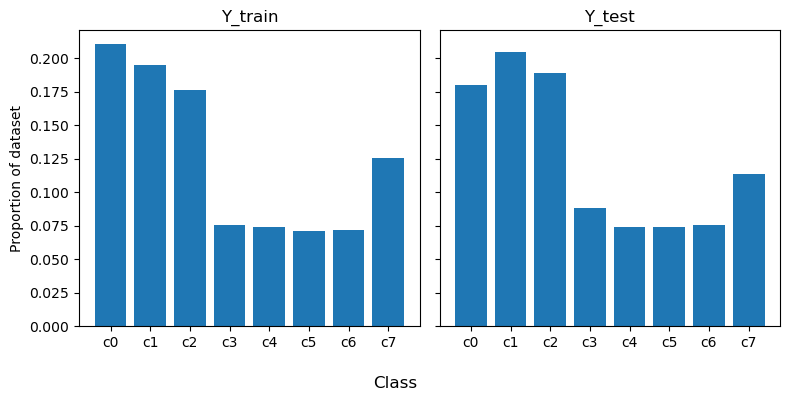

In [11]:
# Distribution of classes in Y_train vs Y_test

y_train_vals,y_train_counts = np.unique(Y_train, return_counts=True)
y_test_vals,y_test_counts = np.unique(Y_test, return_counts=True)

# Normalizing
y_train_counts = np.array(y_train_counts)/sum(y_train_counts)
y_test_counts = np.array(y_test_counts)/sum(y_test_counts)

fig,ax=plt.subplots(ncols=2, sharey=True, figsize=(8,4))
ax[0].bar(x=y_train_vals, height=y_train_counts)
ax[0].set_title('Y_train')
ax[0].set_ylabel('Proportion of dataset')

ax[1].bar(x=y_test_vals, height=y_test_counts)
ax[1].set_title('Y_test')

fig.supxlabel('Class')

plt.tight_layout()
plt.show()

In [31]:
# Trying out undersampling to balance out classes

y_train_vals,y_train_counts = np.unique(Y_train, return_counts=True)
sample_size = np.min(y_train_counts)
print(f'Sample size: {sample_size}')

indices_dict = dict({}) # to store the start and end index for each class in the Y_train array so we can sample

start, end = -1, -1
curr_label = 0
for i in range(len(Y_train)):
    if Y_train[i] == f'c{curr_label}':
        if start == -1:
            start = i
        continue
    end = i
    indices_dict[f'c{curr_label}'] = [start,end]
    start, end = i, -1
    curr_label += 1
indices_dict[f'c{curr_label}'] = [start,i+1]

Sample size: 891


In [32]:
indices_dict # end is exclusive

{'c0': [0, 2640],
 'c1': [2640, 5089],
 'c2': [5089, 7301],
 'c3': [7301, 8254],
 'c4': [8254, 9187],
 'c5': [9187, 10078],
 'c6': [10078, 10976],
 'c7': [10976, 12555]}

In [44]:
# Sampling the indices
sample_indices = []

for label in indices_dict.keys():
    start,end = indices_dict[label]
    sample = np.random.choice(list(range(start,end)), size=sample_size, replace=False)
    sample_indices = np.concatenate((sample_indices, sample))
    
print(f'Size of sampled dataset: {len(sample_indices)}')

Size of sampled dataset: 7128


In [46]:
# Generating a sampled dataset using indices
sample_indices = sample_indices.astype('int')

X_train_s = [X_train[i] for i in sample_indices]
Y_train_s = [Y_train[i] for i in sample_indices]

np.unique(Y_train_s, return_counts=True)

(array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7'], dtype='<U2'),
 array([891, 891, 891, 891, 891, 891, 891, 891]))

## Model

In [137]:
dt = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=35)

# Tuned hyperparameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 35}

### For non-binarized data

In [221]:
# Fit model
dt.fit(X_train, Y_train)
Y_pred = dt.predict(X_test)
accuracy_score(Y_test, Y_pred)

0.1809672386895476

In [222]:
# Saving results
df = pd.DataFrame(dict({'File':X_names,'Truth':Y_test,'Predicted':Y_pred}))
df.to_csv('{}x{}.csv'.format(desired_dim[0],desired_dim[1]))

In [223]:
# Generate just the truth labels
df_truth = df[['File','Truth']]
df_truth.to_csv('truth.csv')

### For binarized data

In [234]:
# Fit model
dt.fit(X_train, Y_train2)
Y_pred2 = dt.predict(X_test)
accuracy_score(Y_test2, Y_pred2)

0.5491419656786272

In [235]:
# Saving results
df = pd.DataFrame(dict({'File':X_names,'Truth':Y_test2,'Predicted':Y_pred2}))
df.to_csv('{}x{}_bin.csv'.format(desired_dim[0],desired_dim[1]))

In [236]:
# Generate just the truth labels
df_truth = df[['File','Truth']]
df_truth.to_csv('truth2.csv')

### For undersampled data

In [138]:
# Fit model
dt.fit(X_train_s, Y_train_s)
Y_pred_s = dt.predict(X_test)
accuracy_score(Y_test, Y_pred_s)

0.20748829953198128

### Repeating to see spread of scores for current best-performing size

In [110]:
# Repeat 5 times for 60x80
acc = []

for i in range(5):
    dt.fit(X_train, Y_train)
    Y_pred = dt.predict(X_test)
    acc.append(accuracy_score(Y_test, Y_pred))

acc

[0.17888715548621945,
 0.18876755070202808,
 0.21112844513780551,
 0.22152886115444617,
 0.1856474258970359]

In [237]:
# Repeat 5 times for 60x80 - binary
acc2 = []

for i in range(5):
    dt.fit(X_train, Y_train2)
    Y_pred2 = dt.predict(X_test)
    acc2.append(accuracy_score(Y_test2, Y_pred2))

acc2

[0.5803432137285491,
 0.6006240249609984,
 0.5741029641185648,
 0.5512220488819553,
 0.5585023400936038]

In [140]:
# Repeat 5 times for 60x80 - undersampled
acc_s = []

for i in range(5):
    dt.fit(X_train_s, Y_train_s)
    Y_pred_s = dt.predict(X_test)
    acc_s.append(accuracy_score(Y_test, Y_pred_s))

acc_s

[0.187727509100364,
 0.15392615704628185,
 0.17264690587623505,
 0.2059282371294852,
 0.15548621944877794]

## Hyperparameter tuning

In [211]:
# Splitting training data into 80% training and 20% validation

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for i, (train_indices, validation_indices) in enumerate(skf.split(X_train, Y_train)):
    print(f'Fold {i}:')
    print(f'Train: {train_indices}')
    print(f'Validation: {validation_indices}')
    print(f'Size of training dataset: {len(train_indices) + len(validation_indices)}')
    print()

Fold 0:
Train: [    0     1     2 ... 12551 12552 12554]
Validation: [   17    22    24 ... 12543 12546 12553]
Size of training dataset: 12555

Fold 1:
Train: [    0     1     4 ... 12551 12552 12553]
Validation: [    2     3     7 ... 12542 12544 12554]
Size of training dataset: 12555

Fold 2:
Train: [    2     3     5 ... 12551 12553 12554]
Validation: [    0     1     4 ... 12547 12550 12552]
Size of training dataset: 12555

Fold 3:
Train: [    0     1     2 ... 12552 12553 12554]
Validation: [   10    12    16 ... 12538 12540 12548]
Size of training dataset: 12555

Fold 4:
Train: [    0     1     2 ... 12552 12553 12554]
Validation: [    5     6     9 ... 12545 12549 12551]
Size of training dataset: 12555



In [81]:
# Test of various max_depths

depth_arr = [i for i in range(20,46,5)]

for i in range(len(depth_arr)):
    n = depth_arr[i]
    dt = DecisionTreeClassifier(max_depth=n, class_weight=None, criterion='entropy')
    score = cross_val_score(estimator=dt, X=X_train, y=Y_train, scoring='accuracy', cv=skf)
    print(f"n = {n:>3d}:\tAverage cross-validation score = {np.mean(score)}")

n =  20:	Average cross-validation score = 0.8601354042214258
n =  25:	Average cross-validation score = 0.8571087216248507
n =  30:	Average cross-validation score = 0.8598964555953804
n =  35:	Average cross-validation score = 0.8608522500995619
n =  40:	Average cross-validation score = 0.8566308243727597
n =  45:	Average cross-validation score = 0.8553564317005178


In [83]:
# Grid-search cross-validation

dt_param_grid = {'criterion': ['gini','entropy'],
                 'max_depth': range(15,41,5), 
                 'class_weight': ['balanced',None]}
dt = DecisionTreeClassifier()
dt_search = GridSearchCV(estimator=dt, param_grid=dt_param_grid, scoring='accuracy', cv=skf).fit(X_train, Y_train)

print(dt_search.best_params_)
print(dt_search.best_score_)

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 35}
0.8641975308641975


## Examining results across different image sizes

In [47]:
result_dfs = sorted(glob.glob('*x*.csv'))
for file in result_dfs:
    print(file)

100x70.csv
120x160.csv
240x320.csv
30x40.csv
54x96.csv
60x80.csv
60x80_bin.csv
70x100.csv
72x128.csv
72x128_bin.csv


In [48]:
# Merging results of experiments

dfs = []
for file in result_dfs:
    df = pd.read_csv(file, index_col='File')
    suffix = file.split(".")[0]
    df.drop(columns=['Unnamed: 0','Truth'],inplace=True)
    df.columns = [f'{df.columns[i]}_{suffix}' for i in range(len(df.columns))]
    dfs.append(df)
    
combined = reduce(lambda left, right: pd.merge(left, right, on='File'), dfs)
combined.head()

,Predicted_100x70,Predicted_120x160,Predicted_240x320,Predicted_30x40,Predicted_54x96,Predicted_60x80,Predicted_60x80_bin,Predicted_70x100,Predicted_72x128,Predicted_72x128_bin
File,,,,,,,,,,
c0/0071.jpg,c0,c7,c1,c7,c1,c4,1,c0,c0,0
c0/00132.jpg,c0,c3,c7,c1,c3,c3,1,c6,c7,0
c0/00126.jpg,c6,c3,c7,c1,c3,c1,1,c6,c7,0
c0/0065.jpg,c5,c7,c7,c1,c1,c4,1,c0,c0,1
c0/107629.jpg,c2,c0,c0,c4,c1,c2,1,c0,c2,0


In [49]:
# Merging results of experiments with truth labels

truth_labels = pd.read_csv('truth.csv')
truth_labels_bin = pd.read_csv('truth2.csv')

for t in [truth_labels, truth_labels_bin]:
    t.drop(columns=['Unnamed: 0'], inplace=True)
    
truth_labels_bin.columns = ['File','Truth_bin']

combined = pd.merge(left=combined, right=truth_labels, on ='File')
combined = pd.merge(left=combined, right=truth_labels_bin, on ='File')
combined.head()

,File,Predicted_100x70,Predicted_120x160,Predicted_240x320,Predicted_30x40,Predicted_54x96,Predicted_60x80,Predicted_60x80_bin,Predicted_70x100,Predicted_72x128,Predicted_72x128_bin,Truth,Truth_bin
0,c0/0071.jpg,c0,c7,c1,c7,c1,c4,1,c0,c0,0,c0,0
1,c0/00132.jpg,c0,c3,c7,c1,c3,c3,1,c6,c7,0,c0,0
2,c0/00126.jpg,c6,c3,c7,c1,c3,c1,1,c6,c7,0,c0,0
3,c0/0065.jpg,c5,c7,c7,c1,c1,c4,1,c0,c0,1,c0,0
4,c0/107629.jpg,c2,c0,c0,c4,c1,c2,1,c0,c2,0,c0,0


In [209]:
# Calculating accuracies

results = [col for col in combined.columns if 'Predicted' in col]
Y_test = combined['Truth']
Y_test_bin = combined['Truth_bin']

for res in results:
    if 'bin' in res:
        print(f'Accuracy for {res.split("_",1)[-1]: >10}: {accuracy_score(Y_test_bin, combined[res])}')
    else:
        print(f'Accuracy for {res.split("_",1)[-1]: >10}: {accuracy_score(Y_test, combined[res])}')

Accuracy for     100x70: 0.18980759230369215
Accuracy for    120x160: 0.18408736349453977
Accuracy for    240x320: 0.1669266770670827
Accuracy for      30x40: 0.2017680707228289
Accuracy for      54x96: 0.17628705148205928
Accuracy for      60x80: 0.21528861154446177
Accuracy for  60x80_bin: 0.578263130525221
Accuracy for     70x100: 0.156526261050442
Accuracy for     72x128: 0.18876755070202808
Accuracy for 72x128_bin: 0.5215808632345293


Highest accuracy seemes to be achieved with size 60x80
* Non-binarized data: 0.21528861154446177
* Binarized data: 0.578263130525221

## Displaying the confusion matrix for each class

### Standard representation

In [60]:
Y_test, Y_test_bin = combined['Truth'], combined['Truth_bin']
Y_pred, Y_pred_bin = combined['Predicted_60x80'], combined['Predicted_60x80_bin']

print(f'Confusion matrix (multiclass)')
cm = confusion_matrix(Y_test, Y_pred)
print(cm)
# Note: Cij = number of observations known to be in group i and predicted to be in group j

print()
print(f'Confusion matrix (binary)')
cm_bin = confusion_matrix(Y_test_bin, Y_pred_bin)
print(cm_bin)

Confusion matrix (multiclass)
[[56 27 98 33 76 11  7 38]
 [57 47 77 67 43 50 13 39]
 [28 16 78 44 80 71  7 40]
 [11  1 15 74  4  7  3 55]
 [11  9  8 29 15 23  6 42]
 [12 12  9  6  8 50 11 35]
 [ 8 11  1 19 23 26  9 49]
 [28 23  9 35 16 14  8 85]]

Confusion matrix (binary)
[[403 399]
 [412 709]]


In [170]:
labels = np.unique(Y_test)

for i in range(len(labels)):
    tp,fp,fn = cm[i][i], sum(cm[:,i]) - cm[i][i], sum(cm[i,:]) - cm[i][i]
    print(f'c{i}: TP - {tp}, FP - {fp}, FN - {fn}')

c0: TP - 56, FP - 155, FN - 290
c1: TP - 47, FP - 99, FN - 346
c2: TP - 78, FP - 217, FN - 286
c3: TP - 74, FP - 233, FN - 96
c4: TP - 15, FP - 250, FN - 128
c5: TP - 50, FP - 202, FN - 93
c6: TP - 9, FP - 55, FN - 137
c7: TP - 85, FP - 298, FN - 133


### Using stacked barplots (with normalized data)

In [122]:
# Get heights of bars

labels = np.unique(Y_test)
cm_norm = np.array([cm[i]/sum(cm[i]) for i in range(len(cm))])

heights = dict({})

for i in range(len(labels)):
    heights[labels[i]] = cm_norm[:,i]

    
# Add in the percentages of classes in training dataset

count_dict = dict({})
total_count = sum(y_train_counts)

for i in range(len(y_train_vals)):
    count_dict[y_train_vals[i]] = y_train_counts[i]/total_count

for label, height in heights.items():
    heights[label] = np.append(height, np.array(count_dict[label]))

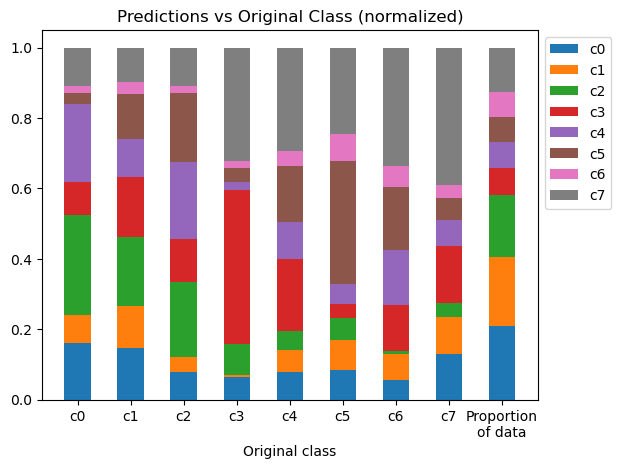

In [133]:
labels = np.unique(Y_test)
labels = np.append(labels, 'Proportion\nof data')

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(9)

for label, height in heights.items():
    ax.bar(labels, height, width, label=label, bottom=bottom)
    bottom += height

ax.set_title('Predictions vs Original Class (normalized)')
ax.set_xlabel('Original class')
ax.legend(bbox_to_anchor=(1,1))

plt.show()

In [155]:
# Doing the same for undersampled data

cm_s = confusion_matrix(Y_test, Y_pred_s)
labels_s = np.unique(Y_test)
cm_s_norm = np.array([cm_s[i]/sum(cm_s[i]) for i in range(len(cm_s))])

heights_s = dict({})

for i in range(len(labels_s)):
    heights_s[labels_s[i]] = cm_s_norm[:,i]

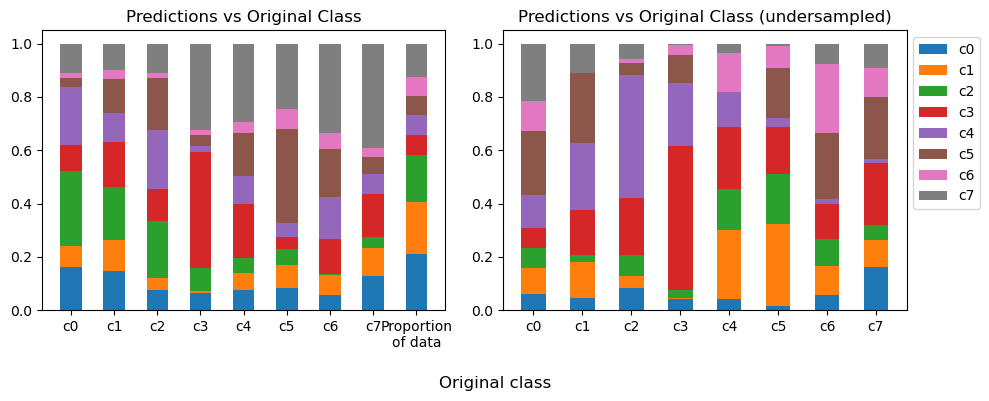

In [162]:
# Plotting together

fig, ax = plt.subplots(ncols=2, figsize=(10,4))

bottom_s = np.zeros(8)
bottom = np.zeros(9)

for label, height in heights.items():
    ax[0].bar(labels, height, width, label=label, bottom=bottom)
    bottom += height

for label, height in heights_s.items():
    ax[1].bar(labels_s, height, width, label=label, bottom=bottom_s)
    bottom_s += height

ax[0].set_title('Predictions vs Original Class')
ax[1].set_title('Predictions vs Original Class (undersampled)')
fig.supxlabel('Original class')
ax[1].legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()

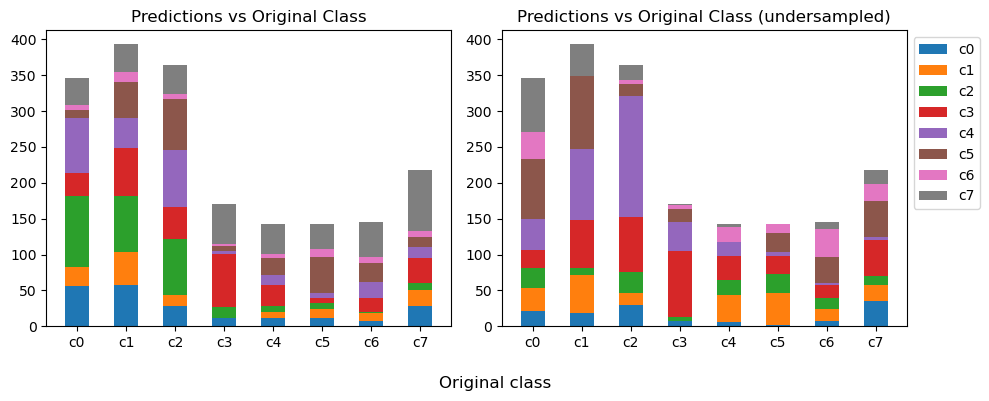

In [164]:
# Non-normalized versions
# Answers the question: of images that were originally from c_, what classes were they predicted to be?

heights_raw = dict({})
heights_s_raw = dict({})

for i in range(len(labels_s)):
    heights_raw[labels_s[i]] = cm[:,i]

for i in range(len(labels_s)):
    heights_s_raw[labels_s[i]] = cm_s[:,i]

fig, ax = plt.subplots(ncols=2, figsize=(10,4))

bottom_s = np.zeros(8)
bottom = np.zeros(8)

for label, height in heights_raw.items():
    ax[0].bar(labels_s, height, width, label=label, bottom=bottom)
    bottom += height

for label, height in heights_s_raw.items():
    ax[1].bar(labels_s, height, width, label=label, bottom=bottom_s)
    bottom_s += height

ax[0].set_title('Predictions vs Original Class')
ax[1].set_title('Predictions vs Original Class (undersampled)')
fig.supxlabel('Original class')
ax[1].legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()

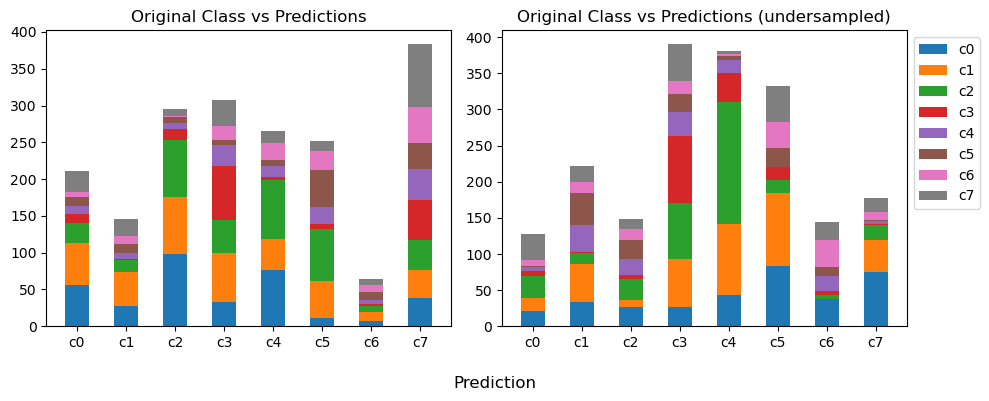

In [165]:
# Original vs Prediction Classes
# Non-normalized versions
# Answers the question: of images that were predicted to be c_, what classes are they originally from?

heights_raw = dict({})
heights_s_raw = dict({})

for i in range(len(labels_s)):
    heights_raw[labels_s[i]] = cm[i,:]

for i in range(len(labels_s)):
    heights_s_raw[labels_s[i]] = cm_s[i,:]

fig, ax = plt.subplots(ncols=2, figsize=(10,4))

bottom_s = np.zeros(8)
bottom = np.zeros(8)

for label, height in heights_raw.items():
    ax[0].bar(labels_s, height, width, label=label, bottom=bottom)
    bottom += height

for label, height in heights_s_raw.items():
    ax[1].bar(labels_s, height, width, label=label, bottom=bottom_s)
    bottom_s += height

ax[0].set_title('Original Class vs Predictions')
ax[1].set_title('Original Class vs Predictions (undersampled)')
fig.supxlabel('Prediction')
ax[1].legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()